<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/main/part-2/Closest%20point/part2_model_based_knn_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNetCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [91]:
oppScrData = pd.read_excel(r'sample_data/OppScrData.xlsx')

In [92]:
def preprocess_clinical_data(oppScrData, mean=True):
    
    l = ['Record ID', 'BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'Age at CT', 'CVD DX', 'Heart failure DX',
                                       'MI DX','Type 2 Diabetes DX', 'Primary Cancer Site', 'Humerus fracture DX',
                                       'Femoral neck fracture DX', 'Unspec femoral fracture DX', 'Forearm fracture DX'
                                       ,'Primary Cancer Site 2','Pathologic fracture DX','DEATH [d from CT]']

    clinical_data = oppScrData.filter(l, axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 

    for col in l[l.index('CVD DX'):l.index('DEATH [d from CT]')]:      
      clinical_data.loc[clinical_data[col].notna(), col] = 1
      clinical_data[col].fillna(value=0, inplace=True)
  
    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [93]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["Record ID", "L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    ct_data['Liver HU    (Median)'].replace(' ', np.nan, inplace=True)
    ct_data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=True)
    return [ct_data, np.array(ct_data, dtype=np.float32)]

In [ ]:
sc = StandardScaler()
ct_data, ct_data_np = clean_ct_data(oppScrData=oppScrData)
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)

In [95]:
combined_data = ct_data.merge(clinical_data, on='Record ID', how='inner' )
combined_data.drop(columns = ['Record ID'], inplace=True)
print(combined_data.columns)
print(combined_data.shape)

Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'BMI', 'BMI >30', 'Sex', 'Tobacco', 'Met Sx',
       'Age at CT', 'CVD DX', 'Heart failure DX', 'MI DX',
       'Type 2 Diabetes DX', 'Primary Cancer Site', 'Humerus fracture DX',
       'Femoral neck fracture DX', 'Unspec femoral fracture DX',
       'Forearm fracture DX', 'Primary Cancer Site 2',
       'Pathologic fracture DX', 'DEATH [d from CT]'],
      dtype='object')
(8878, 29)


In [96]:
non_null_death_rows = combined_data[~combined_data['DEATH [d from CT]'].isnull()]
print(non_null_death_rows.shape)

(493, 29)


In [97]:
# Convert to years
non_null_death_rows['DEATH [d from CT]'] /= 365

m = non_null_death_rows.columns.get_loc('DEATH [d from CT]')

X = non_null_death_rows.iloc[:, 0:m]
y = non_null_death_rows.iloc[:, m]
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
def testWithModel(model, X_train, X_test, y_train, y_test):
  clf = model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(f'MAE = {mean_absolute_error(y_test, y_pred)}') 
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)}')
  print(f'RMSE = {mean_squared_error(y_test, y_pred)**0.5}')

  plot_results(y_test, y_pred)

  return y_pred

In [78]:
def plot_results(y_test, y_pred):
  plt.figure()
  y_test_sub, y_pred_sub = y_test, y_pred
  if len(y_test)>200:
    y_test_sub, y_pred_sub = y_test[::15], y_pred[::15]
    
  x = [i+1 for i in range(len(y_test_sub))]
  plt.plot((x,x),([i for i in y_pred_sub], [j for j in y_test_sub]),c='green',markevery=5,)
  plt.scatter(x, y_pred_sub, label="predicted_y")
  plt.scatter(x, y_test_sub, label="actual_y")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend()
  plt.show()

Train

In [98]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

knn = KNeighborsRegressor()
param_grid2 = dict(weights = ["uniform", "distance"], n_neighbors=list(range(2, 17)))
    
grid = GridSearchCV(knn, param_grid2)
grid.fit(X_train, y_train)
p3 = grid.predict(X_test)
print("MAE: %.2f" %(mean_absolute_error(y_test, p3)))
print(grid.best_params_)

MAE: 2.91
{'n_neighbors': 16, 'weights': 'distance'}


In [ ]:
for idx, row in combined_data.iterrows():  
  if np.isnan(combined_data.at[idx,'DEATH [d from CT]']):
    l = combined_data.columns.drop('DEATH [d from CT]')
    row = combined_data.iloc[idx].drop(columns = ['DEATH [d from CT]'], inplace=True)    
    row = combined_data.iloc[idx]     
    r = row.filter(l).to_numpy().reshape(1, -1) 
    combined_data.at[idx,'DEATH [d from CT]'] = (grid.predict(r))
  else:
    combined_data.at[idx,'DEATH [d from CT]'] /= 365

In [100]:
print(combined_data['DEATH [d from CT]'].isnull().sum())

0


In [101]:
y = combined_data.iloc[:,28]
X = combined_data.iloc[:, 0:28]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

In [102]:
print(X_train.shape)
print(X_test.shape)

(7102, 28)
(1776, 28)


MAE = 0.3619665264546181
MAPE = 0.09446065327732688
RMSE = 0.9191910569765198


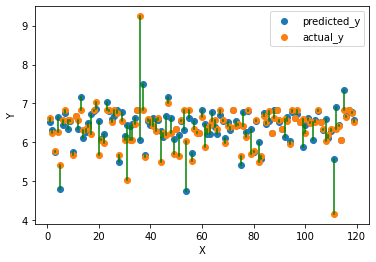

In [103]:
knn = KNeighborsRegressor(n_neighbors=9)
param_grid2 = dict(weights = ["uniform", "distance"])
knn_pred = testWithModel(GridSearchCV(knn, param_grid2),X_train, X_test, y_train, y_test)

MAE = 0.46061581563468096
MAPE = 0.10908258880779567
RMSE = 0.9285811404531296


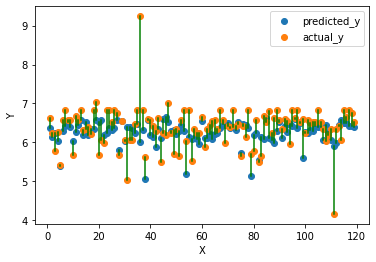

In [104]:
svr_pred = testWithModel(SVR(C=300, epsilon=0.8),X_train, X_test, y_train, y_test)

MAE = 0.41981254081252634
MAPE = 0.10298943024804591
RMSE = 0.9139849923473511


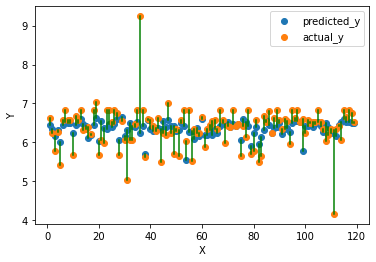

In [105]:
lasso_pred = testWithModel(Lasso(alpha=0.1), X_train, X_test, y_train, y_test)

MAE = 0.4193497582377115
MAPE = 0.10292599339276529
RMSE = 0.9137681509867605


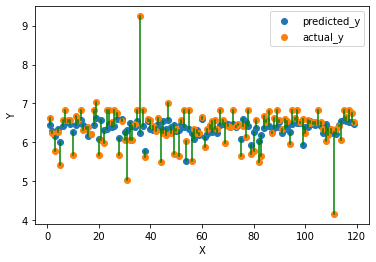

In [106]:
elastic_net_pred = testWithModel(ElasticNetCV(random_state=0), X_train, X_test, y_train, y_test)

MAE = 0.49429277931987436
MAPE = 0.11257425512689107
RMSE = 1.3116968897066135


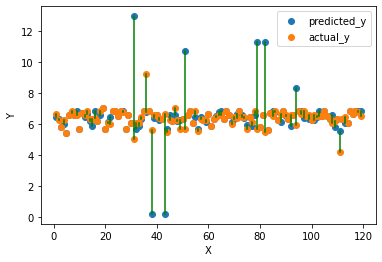

In [107]:
dtree_pred = testWithModel(DecisionTreeRegressor(criterion="absolute_error"),X_train, X_test, y_train, y_test)

In [ ]:
RFparams2={'n_estimators':[50,60,70],
          'min_samples_split':[10,15,20],
          'min_samples_leaf': [4],
           'max_features': [15,18,20],
           'max_depth': [15,20],
           'bootstrap': [True]}

#  {'bootstrap': True, 'max_depth': 20, 'max_features': 21, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 80}

rf = RandomForestRegressor(random_state = 21)
clf_random_forest = GridSearchCV(rf, RFparams2, refit=True)

rf_pred = testWithModel(clf_random_forest ,X_train, X_test, y_train, y_test )
print(clf_random_forest.best_params_)